#Student Performance
Dans ce projet, je vais analyser les les données de performances des étudiants. Ce dataset s’appelle Kalboard 360, collecté en 2016 par le système de management d’étude. 
1. Ce dataset comprend 480 lignes et 16 caractères (features).  Les features sont classé en trois grandes catégories : 
* Caractères démographiques telles que le sexe et la nationalité. 
* Caractères de formation académique telles que le niveau éducatif, le niveau scolaire et la section
* Caractères comportementales, telles que nombre de fois de main levée, visite & discussion des élèves, satisfactions de l’école. 

2. Ces données seront étudiées en 2 étapes : visualisation et model de classification. 
* La partie visualisation nous permet d’avoir une idée de corrélation entre les caractères (features), entre les caractères et les résultats des élève (ici, la ‘‘class’’ des élèves). 
+ L (Low-level) (Niveau bas) : notes entre 0-69
+ M (Middle-Leval) (Niveau moyen) : note entre 70-89
+ H (High-Level) (Niveau élevé) : note entre 90-100

* En deuxième partie, nous allons traiter ces données, c-a-d  ‘‘preprocessing data’’, afin d’avoir une bonne entrée pour les modèles de machine learning. Les modèles choisis sont évidemment des ‘‘Classifier’’, comme DecisionTreeClassifier, RandomForestClassifier, LogisticRegression et GradientBoostingClassifier. 



In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomTreesEmbedding, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#Define some functions
*   Get annotation

In [2]:
def get_annot(ax, distance_to_bar = 0.5, decimal=1):
#to get annotation on barplot
#ax : axis to apply 
#distance_to_bar : distance of annot. position to bar
# decimal : number of decimal 
    for p in ax.patches:
        height = round((p.get_height()),decimal) + distance_to_bar
        ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center", fontsize=15)

* Plot the ROC curves for all classes
* n_classes : number of classes to classification
* y_target : true label in target
* y_score_probas : prediction probability of model on X_test 

In [58]:
def get_ROC(n_classes, y_target, y_score_probas, title):
    #colors = ['blue', 'red']*int(n_classes/2)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score_probas[:, i])
        roc_auc[i] = roc_auc_score(y_test_dummies[:, i], y_score_probas[:, i])


    plt.figure(figsize=(8,6))
    for i in (range(n_classes)):
        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(str(title) + ' : ROC curve', fontsize=18)
    plt.rcParams.update({'font.size': 15})
    plt.show()

In [3]:
uploaded = files.upload()

Saving datasets_436_920_xAPI-Edu-Data.csv to datasets_436_920_xAPI-Edu-Data.csv


In [4]:
df = pd.read_csv('/content/datasets_436_920_xAPI-Edu-Data.csv')
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [5]:
df.shape

(480, 17)

In [6]:
df.columns

Index(['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID',
       'SectionID', 'Topic', 'Semester', 'Relation', 'raisedhands',
       'VisITedResources', 'AnnouncementsView', 'Discussion',
       'ParentAnsweringSurvey', 'ParentschoolSatisfaction',
       'StudentAbsenceDays', 'Class'],
      dtype='object')

In [7]:
df.describe(include='all')

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
count,480,480,480,480,480,480,480,480,480,480.000000,480.000000,480.000000,480.000000,480,480,480,480
unique,2,14,14,3,10,3,12,2,2,NaN,NaN,NaN,NaN,2,2,2,3
top,M,KW,KuwaIT,MiddleSchool,G-02,A,IT,F,Father,NaN,NaN,NaN,NaN,Yes,Good,Under-7,M
freq,305,179,180,248,147,283,95,245,283,NaN,NaN,NaN,NaN,270,292,289,211
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.775000,54.797917,37.918750,43.283333,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.779223,33.080007,26.611244,27.637735,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.750000,20.000000,14.000000,20.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,65.000000,33.000000,39.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,84.000000,58.000000,70.000000,NaN,NaN,NaN,NaN


In [8]:
df.isnull().sum()

gender                      0
NationalITy                 0
PlaceofBirth                0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

3 classes : Low, M (Medium), H (high)

In [9]:
Classes = df['Class'].unique()
Classes.tolist()

['M', 'L', 'H']

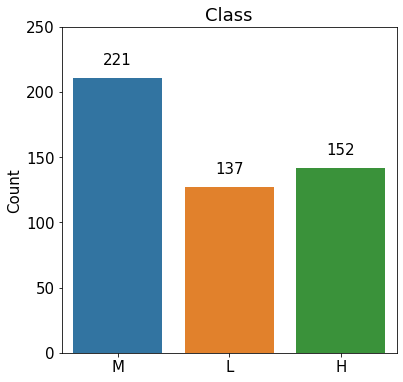

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(df['Class'])
ax.set_xlabel('',fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.ylim([0, 250])
ax.tick_params(labelsize=15)
plt.title('Class', fontsize=18)
get_annot(ax=ax, distance_to_bar=10, decimal=0)
plt.show()

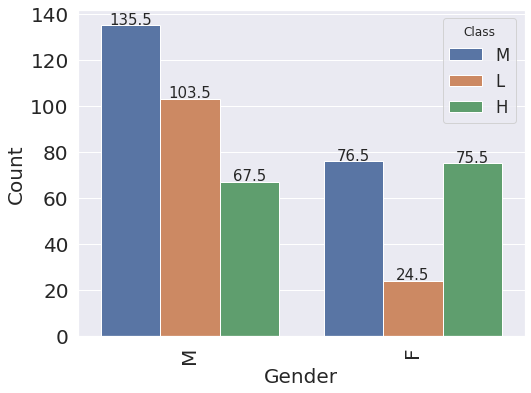

In [67]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x='gender', hue="Class", data=df)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
get_annot(ax=graph)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(labelsize=20)
plt.show()

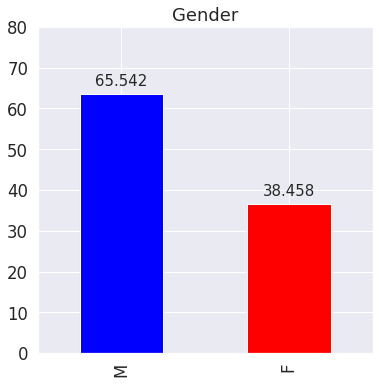

M    0.635417
F    0.364583
Name: gender, dtype: float64

In [68]:
plt.figure(figsize=(6,6))
ax = (df['gender'].value_counts(normalize=True)*100).plot(kind='bar', color = ['blue', 'red'], title='Gender')
plt.ylim([0, 80])
get_annot(ax=ax, decimal=3, distance_to_bar=2)
plt.show()

df['gender'].value_counts(normalize=True)

La plupart des femmes ont de bons résultats, classés en M (Middle-level) et H (High-level). Au contraire, la majorité des hommes sont en classes M et L (Low-level). En corrélation visuelle, on peut dire de : le caractère d’être une femme a un effet positif sur la classe finale, et d’être un homme – effet négatif.

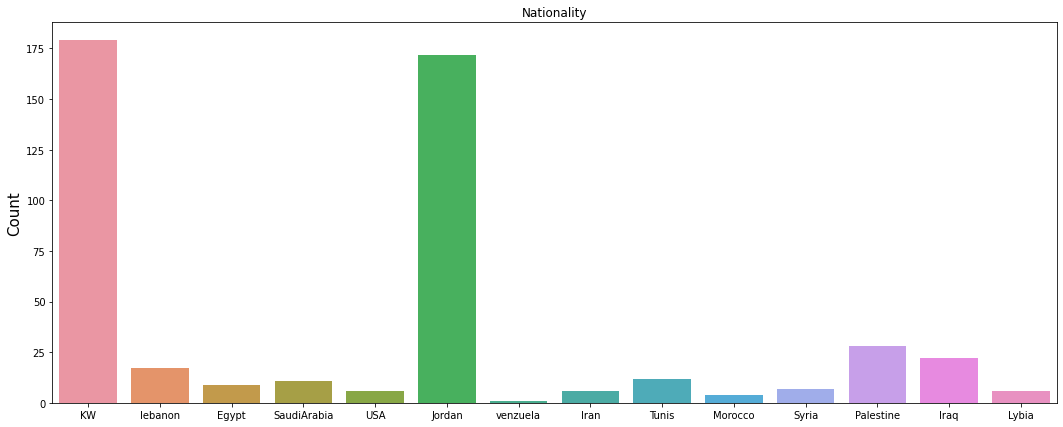

In [11]:
plt.figure(figsize=(18,7))
ax = sns.countplot(df['NationalITy'])
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=15)
plt.title('Nationality')
plt.rcParams.update({'font.size': 15})


In [12]:
df['NationalITy'].value_counts(normalize=True)

KW             0.372917
Jordan         0.358333
Palestine      0.058333
Iraq           0.045833
lebanon        0.035417
Tunis          0.025000
SaudiArabia    0.022917
Egypt          0.018750
Syria          0.014583
Iran           0.012500
Lybia          0.012500
USA            0.012500
Morocco        0.008333
venzuela       0.002083
Name: NationalITy, dtype: float64

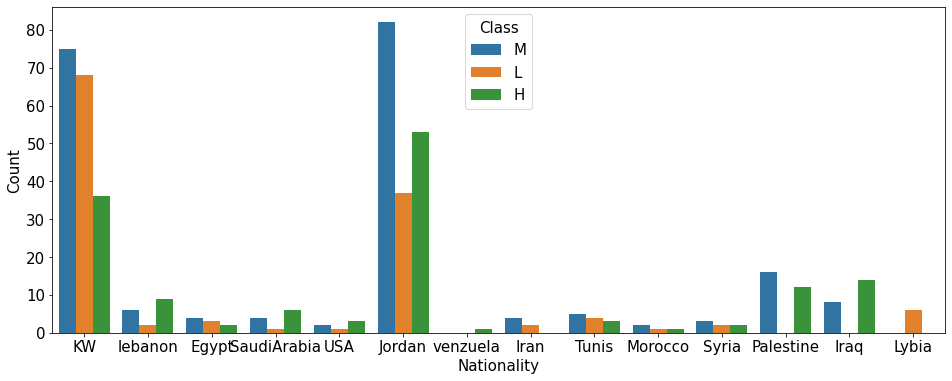

In [13]:
plt.figure(figsize=(16,6))
sns.countplot(x="NationalITy", hue="Class", data = df)
plt.xlabel('Nationality',fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

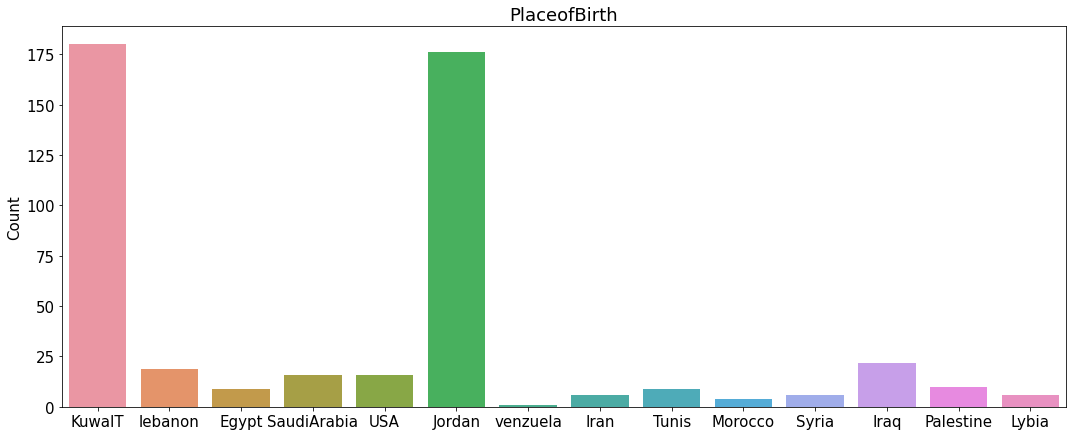

In [14]:
plt.figure(figsize=(18,7))
ax = sns.countplot(df['PlaceofBirth'])
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=15)
plt.title('PlaceofBirth')
plt.rcParams.update({'font.size': 15})

In [15]:
df['PlaceofBirth'].value_counts(normalize=True)

KuwaIT         0.375000
Jordan         0.366667
Iraq           0.045833
lebanon        0.039583
USA            0.033333
SaudiArabia    0.033333
Palestine      0.020833
Egypt          0.018750
Tunis          0.018750
Syria          0.012500
Iran           0.012500
Lybia          0.012500
Morocco        0.008333
venzuela       0.002083
Name: PlaceofBirth, dtype: float64

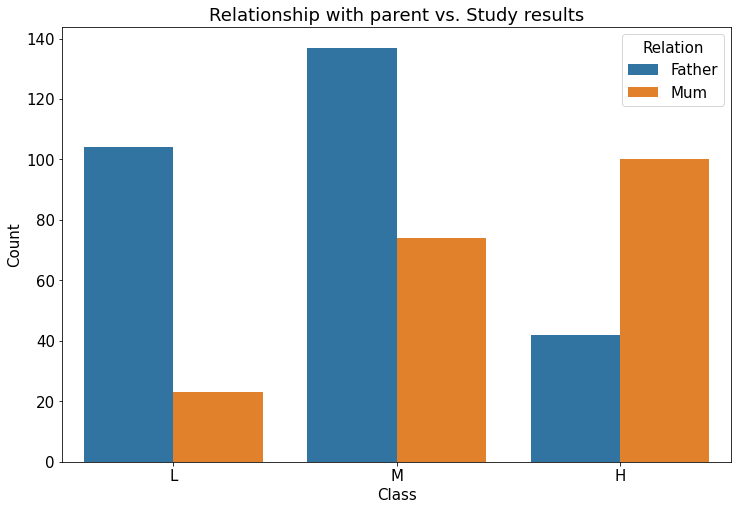

In [17]:
plt.figure(figsize=(12,8))
plot = sns.countplot(x='Class', hue='Relation', data=df, order=['L', 'M', 'H'])
plt.xlabel('Class',fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Relationship with parent vs. Study results')
plt.show()


La plupart des élèves, qui ont de bonne relation avec leur mère, obtiennent des note H e M. Ce caractère a un impact positif sur le résultat d’étude. 

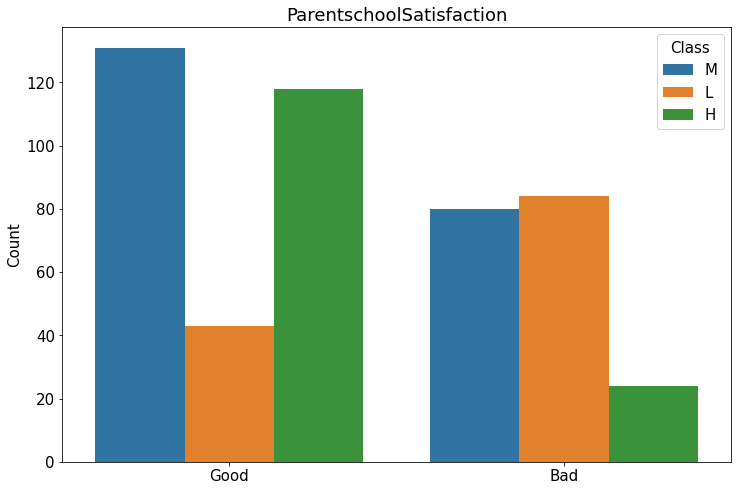

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x="ParentschoolSatisfaction", hue="Class", data = df)
plt.xlabel('',fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('ParentschoolSatisfaction')
plt.show()

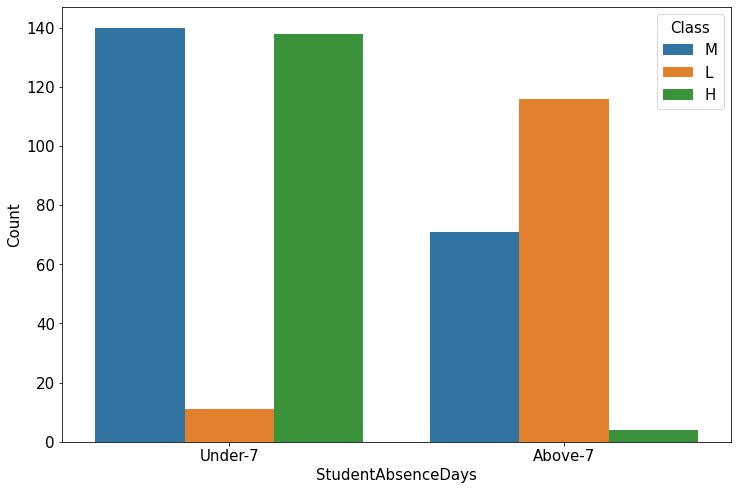

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x="StudentAbsenceDays", hue="Class", data = df)
plt.xlabel('StudentAbsenceDays',fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

La plupart des étudiants de classes M et H ont pris moins de 7 jours d’absence. Contrairement, les étudiants de classe L plus de 7 jours. Donc, ce caractère (moins de 7 jours d’absence) a potentiellement un effet positif sur les classes finales.

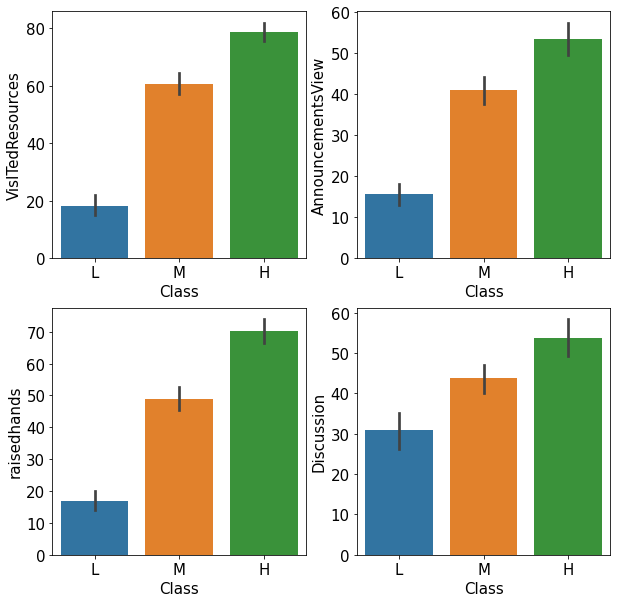

In [20]:
fig, ax  = plt.subplots(2,2,figsize=(10,10))
sns.barplot(x='Class', y='VisITedResources', data=df, order=['L','M','H'], ax=ax[0,0])
sns.barplot(x='Class', y='AnnouncementsView', data=df, order=['L','M','H'], ax=ax[0,1])
sns.barplot(x='Class', y='raisedhands', data=df, order=['L','M','H'], ax=ax[1,0])
sns.barplot(x='Class', y='Discussion', data=df, order=['L','M','H'], ax=ax[1,1])

Les caractères peuvent potentiellement impacter sur les résultats d’études sont : les nombre de discussion, main levée, visite et vue d’annonce. Il est évident que les bons élèves participent activement pendant les cours et les activités de l’écoles ; et les moins bons sont moins manifestent. Par conséquence, ces caractères sont potentiellement des critères, pour classer les classes de résultats. 

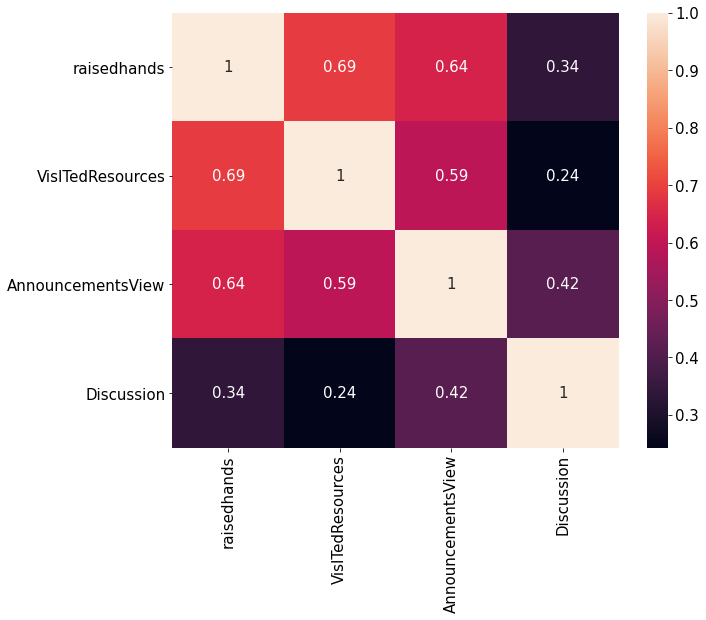

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

#CLASSIFICATION MODELS

In [23]:
X = df.drop('Class', axis=1)
y = df['Class']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [24]:
numeric_features = X.select_dtypes(include=np.number).columns
numeric_features = numeric_features.to_list()

categorical_features = X.select_dtypes(include=object).columns
categorical_features = categorical_features.to_list()

X = X[categorical_features + numeric_features]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
preprocessor = ColumnTransformer(
    transformers = [
                    ("scaler", StandardScaler(), numeric_features),
                    ("onehot", OneHotEncoder(), categorical_features)])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Classifiers : 
* DecisionTreeClassifier
* RandomForestClassifier
* LogisticRegression
* GradientBoostingClassifier

In [27]:
classifiers = [DecisionTreeClassifier(), RandomForestClassifier(),  LogisticRegression(max_iter=800), GradientBoostingClassifier() ]
clf_names = ["decision_tree",  "random_forest","logistic_regression", "gradient_boosting"]
kfold = 3 #nombre de fold

Polynomial Features

In [28]:
degrees = [1,2,3]
lst= []

for model_name, model_class in zip(clf_names,classifiers) :
  print(model_name)
  #print(model_class)
  train_scores = []
  test_scores = []
  for i in range(len(degrees)):
      polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
      pipeline = Pipeline([
                     ("polynomial_features", polynomial_features),
                     ("classifier",model_class)])
      pipeline.fit(X_train, y_train)
      # Evaluate the models using crossvalidation
      train_scores.append(np.mean(cross_val_score(pipeline, X_train, y_train, cv=kfold)))
      test_scores.append(np.mean(cross_val_score(pipeline, X_test, y_test, cv=kfold)))

  lst.append([model_name]+ train_scores + test_scores)

#Print lst as a DataFrame
lst = pd.DataFrame(lst)
lst

decision_tree
random_forest
logistic_regression
gradient_boosting


,0,1,2,3,4,5,6
0,decision_tree,0.705729,0.713542,0.690104,0.729167,0.750000,0.697917
1,random_forest,0.789062,0.804688,0.786458,0.791667,0.729167,0.729167
2,logistic_regression,0.773438,0.729167,0.731771,0.760417,0.708333,0.739583
3,gradient_boosting,0.731771,0.736979,0.742188,0.739583,0.750000,0.729167


* Scores are very close for all cases -> CHOOSE Degrees of Polynomial Features = 1 

Cross validation - GridSearchCV

In [29]:
# Add a dict of estimator and estimator related parameters in this list
params_grid = [{
                'criterion': ['gini', 'entropy'],
                'max_depth': [10, 20, 50, 100, 500],
                'max_leaf_nodes': [10, 20, 50, 100, 500]
                },
                {
                'criterion': ['gini', 'entropy'],
                'max_depth': [10, 20, 50, 100, 500],
                'n_estimators': [10, 50, 100, 200, 500]
                },
               {
                'penalty': ['l2'],
                'C': [0.01, 0.1, 1.0, 10.0],
                'solver': ['saga'],#, 'lbfgs',  'newton-cg'],
                'max_iter':[500, 1000 ]
               }, 
               {
                'max_depth': [5, 10, 100, 200],
                'learning_rate': [0.1, 0.4, 0.5, 1],
                'n_estimators': [200, 400, 600, 800]
               }
              ]
#----------------------------------------------------##

train_score = []
train_cross_score = []
test_score = []
best_estimator = []
feature_importance = []
for index, (name, classifier, params) in enumerate(zip(clf_names,classifiers,params_grid)):
    print(index)
    print(name)
    gs_clf = GridSearchCV(classifier, param_grid=params, cv = kfold)
    gs_clf.fit(X_train, y_train)
    train_score.append(gs_clf.best_score_)
    train_cross_score.append(np.mean(cross_val_score(gs_clf, X_train, y_train, cv=kfold)))
    best_estimator.append(gs_clf.best_estimator_)
    test_score.append(best_estimator[index].score(X_test, y_test))


for p in best_estimator: print(p)
print("Train score : ", train_score)
#print("Train cross score : ", train_cross_score)
print("Test score: ", test_score)

0
decision_tree
1
random_forest
2
logistic_regression
3
gradient_boosting
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
      

In [36]:
df_scores = pd.DataFrame({
    "Model": clf_names,
    "TrainScore": train_score,
    "TestScore": test_score
})
df_scores_sort = df_scores.sort_values(by=['TrainScore'])
df_scores_sort

,Model,TrainScore,TestScore
0,decision_tree,0.723958,0.843750
3,gradient_boosting,0.744792,0.833333
2,logistic_regression,0.773438,0.760417
1,random_forest,0.812500,0.812500


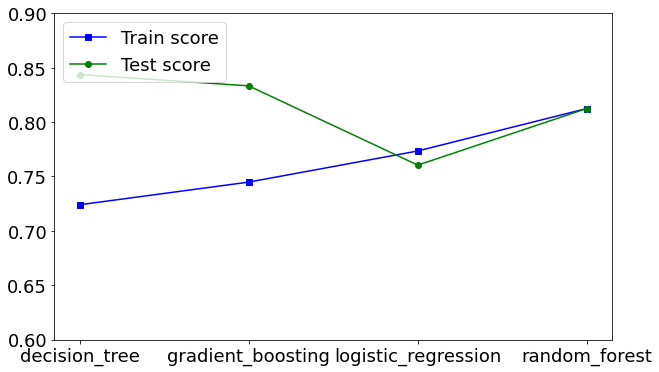

In [31]:
plt.figure(figsize=(10,6))
plt.plot(df_scores_sort['Model'], df_scores_sort['TrainScore'],marker='s', color='blue', label="Train Score" )
plt.plot(df_scores_sort['Model'], df_scores_sort['TestScore'],marker='o',color='green', label="Test Score" )
plt.gca().legend(('Train score','Test score'), loc=2, prop={'size':18})
plt.ylim(0.6, 0.9)
plt.tick_params(labelsize=18)
plt.show()

Afprès hyperparameter tuning, Random Forest montre la meilleure performance : train_score & test_score sont à 81.25%

Random Forest : confusion matrix

In [44]:
best_randomForest = best_estimator[1]

In [69]:
classes_reserve_encoder = labelencoder.inverse_transform([0,1,2])
classes_reserve_encoder

array(['H', 'L', 'M'], dtype=object)

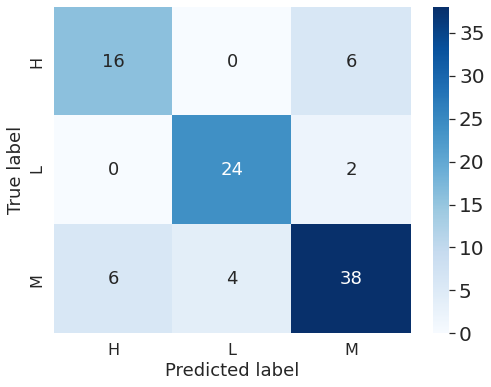

In [71]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_test, best_randomForest.predict(X_test)), annot=True, cmap='Blues')
sns.set(font_scale=1.5)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.set_xticklabels(classes_reserve_encoder)
ax.set_yticklabels(classes_reserve_encoder)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.tick_params(labelsize=16)
plt.show()

ROC : Receiver Operating Characteristic

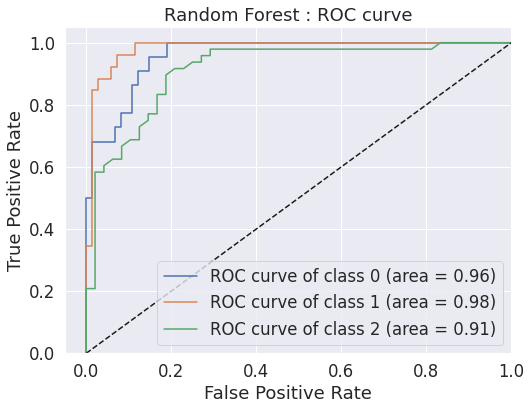

In [60]:
n_classes = df['Class'].unique().shape[0]
get_ROC(n_classes=n_classes, y_target=y_test, y_score_probas=best_randomForest.predict_proba(X_test), title='Random Forest')

Area under curve (AUC) sont très élevé pour les trois classes : 0.96, 0.98, 0.91 pour classe 0 (H), 1 (M) and 2 (L), respectivement. 

Feature Importances

In [33]:
ohe = (preprocessor.named_transformers_['onehot'])

feature_names_ohe = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names_ohe, numeric_features]

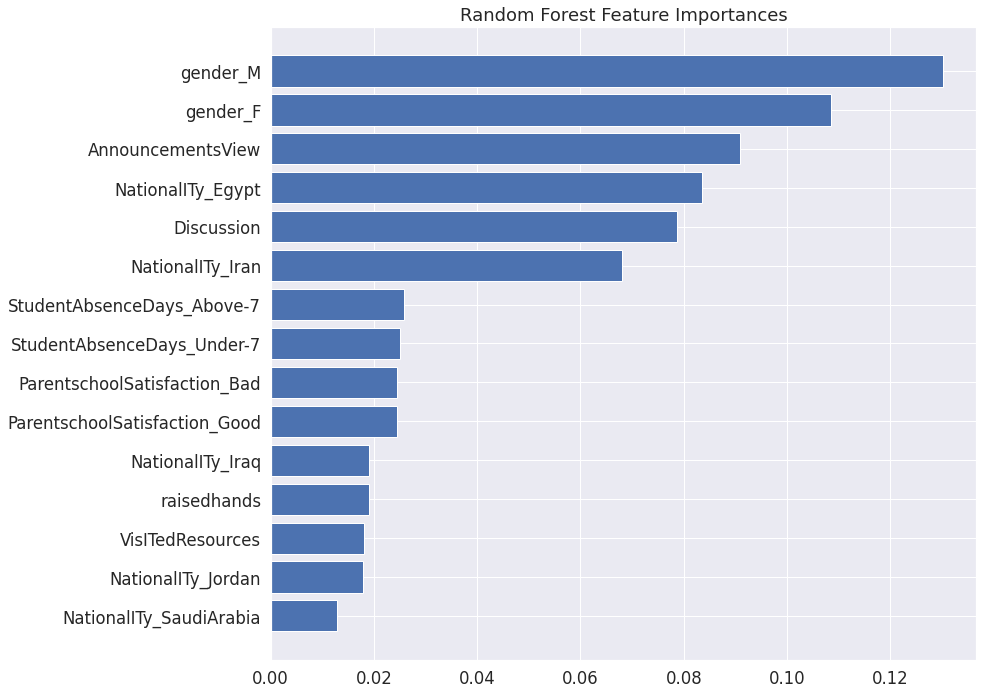

In [34]:
n=15 #take 15 first features 
forest_feature_importances = best_estimator[1].feature_importances_
sorted_idx = forest_feature_importances.argsort()[::-1][:n]

y_ticks = np.arange(0, len(feature_names[sorted_idx]))
fig, ax1 = plt.subplots(1, 1, figsize=(14,10))
ax1.barh(y_ticks, forest_feature_importances[sorted_idx])
ax1.set_yticklabels(feature_names[sorted_idx])
ax1.set_yticks(y_ticks)
ax1.invert_yaxis()

ax1.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

Les factors les plus importants sont :
* gendre (Femme, Homme)
* Announcements View
* Nationality
* Discussion
Les facteurs gendre, Annoncements View e Discussion sont bien prévu, lors de la section visualisation. Par contre, pour la nationalité, on n'a pas vu de l'impact explicit sur le résultat. Donc, un bon modèle de classification est nécessaire pour "mesurer" bien l'importance des facteur. 